## Tile Coding

---
<img src="Tiling.png" alt="drawing" width="800">
Tile coding is a form of coarse coding for multi-dimensional continuous spaces that is flexible and computationally efficient. It may be the most practical feature representation for modern sequential digital computers.


In tile coding the receptive fields of the features are grouped into partitions of the state space. Each such partition is called a tiling, and each element of the partition is called a tile.

---
## Tiling Offset

---
Tilings in all cases are offset from each other by a fraction of a tile width in each dimension. If `w` denotes the tile width and `n` the number of tilings, then `w` is a fundamental `w/n` unit.

In particular, for a continuous space of dimension `k`, a good choice is to use the first odd integers `(1,3,5,7,...,2k-1)`, with `n (the number of tilings)` set to an integer power of 2 greater than or equal to `4k`. (example: `<k = 2, n = 2^3 >= 4k>`)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

For a 2 dimensional space with features `x`, `y`, and `number of tilings = n`, 
then 
> `for each tiling`:
>>   `bins` * `bins`

In [2]:
def create_tiling(feat_range, bins, offset):
    """
    Create 1 tiling spec of 1 dimension(feature)
    feat_range: feature range; example: [-1, 1]
    bins: number of bins for that feature; example: 10
    offset: offset for that feature; example: 0.2
    """
    
    return np.linspace(feat_range[0], feat_range[1], bins+1)[1:-1] + offset

In [3]:
feat_range = [0, 1.0]
bins = 10
offset = 0.2

tiling_spec = create_tiling(feat_range, bins, offset)

tiling_spec

array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1])

In [4]:
def create_tilings(feature_ranges, number_tilings, bins, offsets):
    """
    feature_ranges: range of each feature; example: x: [-1, 1], y: [2, 5] -> [[-1, 1], [2, 5]]
    number_tilings: number of tilings; example: 3 tilings
    bins: bin size for each tiling and dimension; example: [[10, 10], [10, 10], [10, 10]]: 3 tilings * [x_bin, y_bin]
    offsets: offset for each tiling and dimension; example: [[0, 0], [0.2, 1], [0.4, 1.5]]: 3 tilings * [x_offset, y_offset]
    """
    tilings = []
    # for each tiling
    for tile_i in range(number_tilings):
        tiling_bin = bins[tile_i]
        tiling_offset = offsets[tile_i]
        
        tiling = []
        # for each feature dimension
        for feat_i in range(len(feature_ranges)):
            feat_range = feature_ranges[feat_i]
            # tiling for 1 feature
            feat_tiling = create_tiling(feat_range, tiling_bin[feat_i], tiling_offset[feat_i])
            tiling.append(feat_tiling)
        tilings.append(tiling)
    return np.array(tilings)

In [5]:
feature_ranges = [[-1, 1], [2, 5]]  # 2 features
number_tilings = 3
bins = [[10, 10], [10, 10], [10, 10]]  # each tiling has a 10*10 grid
offsets = [[0, 0], [0.2, 1], [0.4, 1.5]]

tilings = create_tilings(feature_ranges, number_tilings, bins, offsets)

print(tilings.shape)  # # of tilings X features X bins

(3, 2, 9)


In [6]:
tilings

array([[[-8.00000000e-01, -6.00000000e-01, -4.00000000e-01,
         -2.00000000e-01,  0.00000000e+00,  2.00000000e-01,
          4.00000000e-01,  6.00000000e-01,  8.00000000e-01],
        [ 2.30000000e+00,  2.60000000e+00,  2.90000000e+00,
          3.20000000e+00,  3.50000000e+00,  3.80000000e+00,
          4.10000000e+00,  4.40000000e+00,  4.70000000e+00]],

       [[-6.00000000e-01, -4.00000000e-01, -2.00000000e-01,
          5.55111512e-17,  2.00000000e-01,  4.00000000e-01,
          6.00000000e-01,  8.00000000e-01,  1.00000000e+00],
        [ 3.30000000e+00,  3.60000000e+00,  3.90000000e+00,
          4.20000000e+00,  4.50000000e+00,  4.80000000e+00,
          5.10000000e+00,  5.40000000e+00,  5.70000000e+00]],

       [[-4.00000000e-01, -2.00000000e-01,  1.11022302e-16,
          2.00000000e-01,  4.00000000e-01,  6.00000000e-01,
          8.00000000e-01,  1.00000000e+00,  1.20000000e+00],
        [ 3.80000000e+00,  4.10000000e+00,  4.40000000e+00,
          4.70000000e+00,  5.00

In [7]:
def get_tile_coding(feature, tilings):
    """
    feature: sample feature with multiple dimensions that need to be encoded; example: [0.1, 2.5], [-0.3, 2.0]
    tilings: tilings with a few layers
    return: the encoding for the feature on each layer
    """
    num_dims = len(feature)
    feat_codings = []
    for tiling in tilings:
        feat_coding = []
        for i in range(num_dims):
            feat_i = feature[i]
            tiling_i = tiling[i]  # tiling on that dimension
            coding_i = np.digitize(feat_i, tiling_i)
            feat_coding.append(coding_i)
        feat_codings.append(feat_coding)
    return np.array(feat_codings)

In [8]:
feature = [0.1, 2.5]

coding = get_tile_coding(feature, tilings)
coding

array([[5, 1],
       [4, 0],
       [3, 0]])

### Q table & Tiling combine
---
For each tiling, there is a q table with size `<state_dim1 * state_dim2 * ... * action>`

In [44]:
class QValueFunction:
    
    def __init__(self, tilings, actions, lr):
        self.tilings = tilings
        self.num_tilings = len(self.tilings)
        self.actions = actions
        self.lr = lr / self.num_tilings  # learning rate equally assigned to each tiling
        self.state_sizes = [tuple(len(splits)+1 for splits in tiling) for tiling in self.tilings]  # [(10, 10), (10, 10), (10, 10)]
        self.q_tables = [np.zeros(shape=(state_size+(len(self.actions),))) for state_size in self.state_sizes]
        
    def value(self, state, action):
        state_codings = get_tile_coding(state, self.tilings)  # [[5, 1], [4, 0], [3, 0]] ...
        action_idx = self.actions.index(action)
        
        value = 0
        for coding, q_table in zip(state_codings, self.q_tables):
            value += q_table[tuple(coding)+(action_idx,)]
        return value # / self.num_tilings
    
    def update(self, state, action, target):
        state_codings = get_tile_coding(state, self.tilings)  # [[5, 1], [4, 0], [3, 0]] ...
        action_idx = self.actions.index(action)
        
        delta = self.lr*(target - self.value(state, action))
        for coding, q_table in zip(state_codings, self.q_tables):
#             delta = target - q_table[tuple(coding)+(action_idx,)]
#             q_table[tuple(coding)+(action_idx,)] += self.lr*(delta)
            q_table[tuple(coding)+(action_idx,)] += delta
#             print("index {} delta {} final value {}".format(tuple(coding)+(action_idx,), delta, q_table[tuple(coding)+(action_idx,)]))
    
    # get the # of steps to reach the goal under current state value function
    def costToGo(self, state):
        costs = []
        for action in self.actions:
            costs.append(self.value(state, action))
        return -np.max(costs)

In [40]:
feature_ranges = [[-1, 1], [2, 5]]  # 2 features
number_tilings = 3
bins = [[10, 10], [10, 10], [10, 10]]  # each tiling has a 10*10 grid
offsets = [[0, 0], [0.2, 1], [0.4, 1.5]]

tilings = create_tilings(feature_ranges, number_tilings, bins, offsets)

q = QValueFunction(tilings, [-1, 0, 3], 0.1)

In [47]:
q.update([0.3, 2.4], -1, 2.1)
q.update([0.3, 2.4], -1, -10)
q.value([0.3, 4], -1)

0.0

## Apply on Mountain Car

In [34]:
class MountainCar:
    
    def __init__(self, n=1, exp_rate=0.1, gamma=1, debug=True):
        self.actions = [-1, 0, 1]  # reverse, 0 and forward throttle
        self.state = (-0.5, 0)  # position, velocity
        self.exp_rate = exp_rate
        self.gamma = 1
        self.end = False
        self.n = n  # step of learning
        self.debug = debug
        
    def reset(self):
        pos = np.random.uniform(-0.6, -0.4)
        self.end = False
        self.state = (pos, 0)
        
    def takeAction(self, action):
        pos, vel = self.state
        
        vel_new = vel + 0.001*action - 0.0025*np.cos(3*pos)
        vel_new = min(max(vel_new, VELOCITY_BOUND[0]), VELOCITY_BOUND[1])
        
        pos_new = pos + vel_new
        pos_new = min(max(pos_new, POSITION_BOUND[0]), POSITION_BOUND[1])
        
        if pos_new == POSITION_BOUND[0]:
            # reach leftmost, set speed to 0
            vel_new = 0
        self.state = (pos_new, vel_new)
        return self.state
    
    def chooseAction(self, valueFunc):
        # choose an action based on the current state, 
        if np.random.uniform(0, 1) <= self.exp_rate:
            # random action
            return np.random.choice(self.actions)
        else:
            # greedy action
            values = {}
            for a in self.actions:
                value = valueFunc.value(self.state, a)
                values[a] = value
            return np.random.choice([k for k, v in values.items() if v==max(values.values())])
        
    def giveReward(self):
        pos, _ = self.state
        if pos == POSITION_BOUND[1]:
            self.end = True
            return 0
        return -1
        
    def play(self, valueFunction, rounds=1):
        for rnd in range(1, rounds+1):
            self.reset()
            t = 0
            T = np.inf
            action = self.chooseAction(valueFunction)
            
            actions = [action]
            states = [self.state]
            rewards = [-1]
            
            while True:
                if t < T:
                    print("state {} take action {}".format(self.state, action))
                    state = self.takeAction(action)  # next state
                    reward = self.giveReward()  # next state-reward
                    
                    states.append(state)
                    rewards.append(reward)
                    
                    if self.end:
                        if self.debug:
                            if rnd % 100 == 0:
                                print("Round {}: End at state {} | number of states {}".format(rnd, state, len(states)))
                        T = t+1
                    else:
                        action = self.chooseAction(valueFunction)
                        actions.append(action)  # next action
                # state tau being updated
                tau = t - self.n + 1
                if tau >= 0:
                    G = 0
                    for i in range(tau+1, min(tau+self.n+1, T+1)):
                        G += np.power(self.gamma, i-tau-1)*rewards[i]
                    if tau+self.n < T:
                        state = states[tau+self.n]
                        G += np.power(self.gamma, self.n)*valueFunction.value(state, actions[tau+self.n])
                    # update value function
                    state = states[tau]  # tau is the state to update
                    valueFunction.update(state, actions[tau], G)
                    
                if tau == T-1:
                    break
                
                t += 1

In [29]:
VELOCITY_BOUND = [-0.07, 0.07]
POSITION_BOUND = [-1.2, 0.5]
ACTIONS = [-1, 0, 1]

In [30]:
feature_ranges = [POSITION_BOUND, VELOCITY_BOUND]  # 2 features
number_tilings = 8
bins = [[16, 16] for _ in range(number_tilings)]
offsets = [[i, j] for i, j in zip(np.linspace(POSITION_BOUND[0], POSITION_BOUND[1], number_tilings), np.linspace(VELOCITY_BOUND[0], VELOCITY_BOUND[1], number_tilings))]

tilings = create_tilings(feature_ranges=feature_ranges, number_tilings=number_tilings, bins=bins, offsets=offsets)

In [31]:
print("tiling shape: \n", tilings.shape)
print("offsets: \n", offsets)

tiling shape: 
 (8, 2, 15)
offsets: 
 [[-1.2, -0.07], [-0.9571428571428571, -0.05], [-0.7142857142857142, -0.030000000000000006], [-0.4714285714285714, -0.010000000000000009], [-0.22857142857142854, 0.009999999999999995], [0.014285714285714235, 0.03], [0.2571428571428571, 0.04999999999999999], [0.5, 0.07]]


In [37]:
valueFunc = QValueFunction(tilings, ACTIONS, 0.3)
mc = MountainCar()  # 1 step sarsa
mc.play(valueFunc, rounds=1)

state (-0.5211187247119132, 0) take action -1
index (15, 15, 0) delta -1.0 final value -0.3
index (15, 13, 0) delta -1.0 final value -0.3
index (13, 11, 0) delta -1.0 final value -0.3
index (10, 9, 0) delta -1.0 final value -0.3
index (8, 6, 0) delta -1.0 final value -0.3
index (6, 4, 0) delta -1.0 final value -0.3
index (3, 2, 0) delta -1.0 final value -0.3
index (1, 0, 0) delta -1.0 final value -0.3
state (-0.5221373249219549, -0.001018600210041644) take action -1
index (15, 15, 0) delta -0.7 final value -0.51
index (15, 13, 0) delta -0.7 final value -0.51
index (13, 11, 0) delta -0.7 final value -0.51
index (10, 9, 0) delta -0.7 final value -0.51
index (8, 6, 0) delta -0.7 final value -0.51
index (6, 4, 0) delta -0.7 final value -0.51
index (3, 2, 0) delta -0.7 final value -0.51
index (1, 0, 0) delta -0.7 final value -0.51
state (-0.5241668859769532, -0.0020295610549982603) take action 1
index (15, 15, 2) delta -1.0 final value -0.3
index (15, 13, 2) delta -1.0 final value -0.3
inde

index (15, 15, 2) delta 0.20700350703154657 final value -1.9480143756973027
index (15, 14, 2) delta 0.9316766351313583 final value -2.4552855653671712
index (12, 12, 2) delta -0.46240422727244845 final value -1.4794289616845062
index (10, 10, 2) delta -1.004902599918565 final value -1.0996801008322246
index (8, 8, 2) delta -1.8031119207752202 final value -0.540933576232566
index (5, 5, 2) delta -0.6054323794972274 final value -1.379309255127161
index (3, 3, 2) delta -0.7249285380176451 final value -1.2956619441628687
index (1, 1, 2) delta -1.8031119207752202 final value -0.540933576232566
state (-0.5510132453954799, 0.011485417922577222) take action 1
index (15, 15, 2) delta 0.3211722609625669 final value -1.8516626974085326
index (15, 15, 2) delta -1.6268421147347358 final value -0.48805263442042074
index (12, 12, 2) delta -0.14741315305022962 final value -1.523652907599575
index (10, 10, 2) delta -0.5271620139025113 final value -1.257828705002978
index (8, 8, 2) delta -1.085908538502

index (14, 11, 1) delta -2.0792385548676338 final value -0.6237715664602901
index (12, 9, 1) delta -1.3924921695792238 final value -1.104494036162177
index (10, 7, 1) delta -0.27186391002144505 final value -1.8889338178526223
index (8, 4, 1) delta -1.518513734034043 final value -1.0162789410438036
index (5, 2, 1) delta -2.0792385548676338 final value -0.6237715664602901
index (3, 0, 1) delta -0.5012016018246259 final value -1.7283974335903955
index (1, 0, 1) delta 0.4375659701348833 final value -2.385534733962052
state (-0.5844860073265068, -0.01724722975495812) take action 0
index (15, 14, 1) delta -0.08558941183682478 final value -2.070622754311996
index (14, 11, 1) delta -1.5067637761374832 final value -1.075800699301535
index (12, 9, 1) delta -1.0260413064355964 final value -1.412306428092856
index (10, 7, 1) delta -0.24160152474515106 final value -1.9614142752761676
index (7, 4, 1) delta -2.1305353425977733 final value -0.639160602779332
index (5, 2, 1) delta -1.5067637761374832 f

index (12, 13, 0) delta -0.1018450465425309 final value -1.6516948884506368
index (9, 11, 0) delta -1.0223182655908745 final value -1.0073636351167963
index (7, 9, 0) delta -1.2793608998043249 final value -0.827433791167381
index (5, 7, 0) delta -1.7229864210304084 final value -0.5168959263091225
index (3, 4, 0) delta -0.5546785246572086 final value -1.3347114537703624
index (0, 2, 0) delta -1.0223182655908745 final value -1.0073636351167963
state (-0.5939036724436658, 0.021474165408772717) take action 1
index (15, 15, 2) delta -0.032396251079772176 final value -1.5353820918274845
index (14, 15, 2) delta 0.06020841443452962 final value -1.6002053576874957
index (12, 13, 2) delta -0.23864384000665595 final value -1.3910087795786659
index (10, 11, 2) delta -1.0786888078506085 final value -0.802977302087899
index (7, 9, 2) delta -1.558059467583325 final value -0.4674178402749975
index (5, 7, 2) delta -1.558059467583325 final value -0.4674178402749975
index (3, 4, 2) delta -0.7168854851708

index (13, 8, 0) delta -1.3817630046211913 final value -1.2128390997666423
index (11, 6, 0) delta -1.3817630046211913 final value -1.2128390997666423
index (9, 4, 0) delta -1.1788307225326662 final value -1.3548916972286098
index (6, 2, 0) delta -0.33210314729925794 final value -1.9476009998919956
index (4, 0, 0) delta -0.42235769889935026 final value -1.884422813771931
index (2, 0, 0) delta -0.2651000224305804 final value -1.99450318730007
state (-0.4674566650588902, -0.02382128348795354) take action -1
index (15, 13, 0) delta -0.1365848333767128 final value -2.021239537454361
index (15, 10, 0) delta -1.3185387224377751 final value -1.1938718151116174
index (13, 8, 0) delta -0.9040098210514178 final value -1.4840420460820676
index (11, 6, 0) delta -0.9040098210514178 final value -1.4840420460820676
index (9, 4, 0) delta -0.7619572235894503 final value -1.583478864305445
index (6, 1, 0) delta -1.639756666433085 final value -0.9690192543149005
index (4, 0, 0) delta -0.2324261070461291 f

index (15, 15, 2) delta 0.10631959780350964 final value -1.7467727072990291
index (13, 15, 2) delta -0.38089421263638346 final value -1.4057230399911038
index (11, 14, 2) delta -0.9303268348560862 final value -1.021120204437312
index (8, 12, 2) delta -1.6723489888365723 final value -0.5017046966509717
index (6, 9, 2) delta -0.9303268348560862 final value -1.021120204437312
index (4, 7, 2) delta -0.9303268348560862 final value -1.021120204437312
index (2, 5, 2) delta -1.260036868890905 final value -0.7903231806129388
index (0, 3, 2) delta -1.6723489888365723 final value -0.5017046966509717
state (-0.6970971287901393, 0.029814588142454246) take action 1
index (15, 15, 2) delta 0.09354099415481243 final value -1.7187104090525853
index (13, 15, 2) delta -0.24750867315311287 final value -1.4799756419370378
index (11, 14, 2) delta -0.6321115087069047 final value -1.2107536570493833
index (9, 12, 2) delta -1.2409195931985493 final value -0.7845879979052321
index (6, 10, 2) delta -1.6532317131

index (15, 14, 2) delta -0.2116373227659185 final value -2.1309486836332017
index (15, 11, 2) delta -0.14729850012456414 final value -2.1759858594821497
index (15, 9, 2) delta -0.5182027881948559 final value -1.9163528578329454
index (14, 7, 2) delta -1.706492735440556 final value -1.0845498947609555
index (12, 5, 2) delta -1.3091598430151277 final value -1.3626829194587553
index (10, 2, 2) delta -2.2790948095693446 final value -0.6837284428708034
index (7, 0, 2) delta -0.9155100821599129 final value -1.6382377520574056
index (5, 0, 2) delta -0.44005860424322796 final value -1.9710537865990851
state (-0.13260241119594204, -0.017566781375088637) take action -1
index (15, 13, 0) delta -0.25570235150094556 final value -1.9314389277547066
index (15, 11, 0) delta -0.11322184947818004 final value -2.0311752791706423
index (15, 9, 0) delta -0.6098720487058102 final value -1.6835201397113013
index (14, 7, 0) delta -0.7611166876935631 final value -1.5776488924198744
index (12, 4, 0) delta -2.11

index (13, 15, 1) delta -0.37702283158042005 final value -1.8859680664998129
index (11, 14, 1) delta -0.8892663722129794 final value -1.5273975880570212
index (8, 12, 1) delta -2.149884048606107 final value -0.644965214581832
index (6, 9, 1) delta -0.5006774581430882 final value -1.7994098279059452
index (4, 7, 1) delta -0.6625020707858313 final value -1.686132599056025
index (2, 5, 1) delta -1.0722856312384095 final value -1.39928410673922
index (0, 3, 1) delta -1.048705898385904 final value -1.415789919735974
index (0, 0, 1) delta -0.24406621294108843 final value -1.9790376995473449
state (-0.9564655304895486, 0.009783263995273565) take action 0
index (13, 15, 1) delta -0.11736693890011907 final value -1.9211781481698487
index (11, 14, 1) delta -0.47593741734291073 final value -1.6701788132598945
index (9, 12, 1) delta -1.0084812409100787 final value -1.2973981367628769
index (6, 10, 1) delta -2.003335005399932 final value -0.6010005016199795
index (4, 7, 1) delta -0.3172024063439069

index (15, 15, 1) delta -0.11948174647291632 final value -2.6948532668107257
index (15, 13, 1) delta -0.5927612065149206 final value -2.3635576447813227
index (15, 10, 1) delta -0.5314380707944046 final value -2.406483839785684
index (14, 8, 1) delta -2.2581202450666766 final value -1.1978063177950935
index (12, 6, 1) delta -0.8703905911605359 final value -2.1692170755293922
index (10, 3, 1) delta -0.9969804064690522 final value -2.080604204813431
index (7, 1, 1) delta -1.8206276112699815 final value -1.50405116145278
index (5, 0, 1) delta -0.2689681782083122 final value -2.5902127645959485
state (-0.13055940816826472, -0.00805895894135023) take action 0
index (15, 15, 1) delta -0.2406820553343052 final value -2.767057883411017
index (15, 12, 1) delta -0.6268675161312625 final value -2.496728060853147
index (15, 10, 1) delta -0.5290514823593471 final value -2.565199284493488
index (14, 8, 1) delta -1.7377290043499374 final value -1.7191250191000746
index (12, 5, 1) delta -1.19975443885

index (7, 1, 1) delta -1.2975246739778956 final value -0.972244721129003
index (5, 0, 1) delta -0.0831837407307836 final value -1.8222833744019813
index (2, 0, 1) delta 0.5266897365066945 final value -2.249194808468216
index (0, 0, 1) delta 0.5783334484120726 final value -2.2853454068019805
state (-0.683577128465601, -0.04701119930567741) take action -1
index (15, 10, 0) delta -0.9408807393866048 final value -1.2152032116809421
index (13, 8, 0) delta -1.8738197292515655 final value -0.5621459187754696
index (11, 6, 0) delta -1.8738197292515655 final value -0.5621459187754696
index (9, 3, 0) delta -1.8738197292515655 final value -0.5621459187754696
index (7, 1, 0) delta -1.8738197292515655 final value -0.5621459187754696
index (4, 0, 0) delta -0.46007004141289465 final value -1.5517707002625392
index (2, 0, 0) delta 0.36928453404398853 final value -2.1323189030823575
index (0, 0, 0) delta 0.5804832730574891 final value -2.280158020391808
state (-0.730434023841585, -0.04685689537598395) 

index (15, 15, 2) delta 0.23403619557845934 final value -1.9196978578755008
index (15, 15, 2) delta 0.13388347961777614 final value -1.8495909567030224
index (13, 15, 2) delta -0.01010520372953616 final value -1.748798878359904
index (11, 14, 2) delta -1.2462392854463324 final value -0.8835050211581466
index (9, 12, 2) delta -1.7558725209705792 final value -0.5267617562911737
index (6, 9, 2) delta -0.572198820132948 final value -1.3553333468775157
index (4, 7, 2) delta -0.8044526886116805 final value -1.1927556389424028
index (2, 5, 2) delta -1.2462392854463324 final value -0.8835050211581466
state (-0.4103153580421577, 0.04784577326074154) take action 1
index (15, 15, 2) delta 0.24372970132515204 final value -1.8465789474779553
index (15, 15, 2) delta 0.17362280015267362 final value -1.7975041166572203
index (14, 15, 2) delta -0.5279191769716023 final value -1.3064247326702272
index (11, 14, 2) delta -0.7924631353922023 final value -1.1212439617758072
index (9, 12, 2) delta -1.1492064

index (15, 12, 0) delta -0.32267047086570244 final value -2.371540274620898
index (15, 10, 0) delta -0.5940540064877324 final value -2.181571799685477
index (14, 8, 0) delta -1.9053862365393845 final value -1.2636392386493207
index (12, 5, 0) delta -2.5974096042268897 final value -0.7792228812680669
index (9, 3, 0) delta -1.1068174915529307 final value -1.8226373601398382
index (7, 1, 0) delta -1.4177881358779263 final value -1.6049579091123414
state (0.11070812509519967, 0.008151135315829346) take action 1
index (15, 15, 2) delta -0.45068845715961237 final value -2.3022319301325083
index (15, 14, 2) delta -0.36213044021864693 final value -2.364222541991184
index (15, 12, 2) delta -0.4000589338372187 final value -2.3376725964581837
index (15, 10, 2) delta -0.7692212469706745 final value -2.079258977264765
index (14, 7, 2) delta -1.5415780485317714 final value -1.5386092161719969
index (12, 5, 2) delta -2.617713850144237 final value -0.7853141550432711
index (9, 3, 2) delta -1.477558427

index (14, 11, 2) delta -1.3230981701624915 final value -1.1878370399589575
index (11, 9, 2) delta -0.9925923300516102 final value -1.4191911280365745
index (9, 6, 2) delta -1.6563066839667486 final value -0.9545910802959776
index (7, 4, 2) delta -1.6563066839667486 final value -0.9545910802959776
index (5, 2, 2) delta -1.2092045640723572 final value -1.2675625642220516
index (2, 0, 2) delta -0.9925923300516102 final value -1.4191911280365745
index (0, 0, 2) delta -0.31518851911228585 final value -1.8933737956941017
index (0, 0, 2) delta 0.1867154760490779 final value -2.244706592307056
state (-0.9189238968500583, -0.03649111409103921) take action -1
index (13, 11, 0) delta -1.7366231519574482 final value -0.939009378325038
index (11, 9, 0) delta -1.7147073480265367 final value -0.9543504410766759
index (9, 7, 0) delta -1.0239372000467168 final value -1.43788954466255
index (7, 4, 0) delta -1.292585925793221 final value -1.249835436639997
index (4, 2, 0) delta -1.7147073480265367 final

Text(0.5,0,'Cost to go')

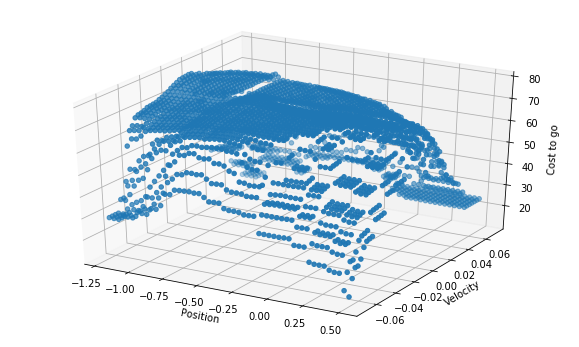

In [187]:
# step 100
grids = 50

positions = np.linspace(POSITION_BOUND[0], POSITION_BOUND[1], grids)
vels = np.linspace(VELOCITY_BOUND[0], VELOCITY_BOUND[1], grids)

x = []
y = []
z = []
for p in positions:
    for v in vels:
        x.append(p)
        y.append(v)
        z.append(valueFunc.costToGo([p, v]))

fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)

ax.set_xlabel("Position")
ax.set_ylabel("Velocity")
ax.set_zlabel("Cost to go")

## Apply on Random Walk

In [39]:
NUM_STATES = 1000
START = 500
END_0 = 0
END_1 = 1001

TRUE_VALUES = np.arange(-1001, 1003, 2) / 1001.0

In [40]:
class RandomWalk:

    def __init__(self, step=1, lr=2e-5, exp_rate=0.2, gamma=1, debug=True):
        self.state = START
        self.actions = ["left", "right"]
        self.end = False
        self.n = step
        self.lr = lr
        self.gamma = gamma
        self.exp_rate = exp_rate
        self.debug = debug

    def chooseAction(self, valueFunc):
        # choose an action based on the current state, 
        if np.random.uniform(0, 1) <= self.exp_rate:
            # random action
            return np.random.choice(self.actions)
        else:
            # greedy action
            values = {}
            for a in self.actions:
                value = valueFunc.value([self.state], a)
                values[a] = value
            return np.random.choice([k for k, v in values.items() if v==max(values.values())])

        return action

    def takeAction(self, action):
        # choose steps from 1 to 100
        steps = np.random.choice(range(1, 101))
        if action == "left":
            state = self.state - steps
        else:
            state = self.state + steps
        # judge if end of game
        if state <= END_0 or state >= END_1:
            self.end = True
            if state <= END_0:
                state = END_0
            else:
                state = END_1

        self.state = state
        return state

    def giveReward(self):
        if self.state == END_0:
            return -1
        if self.state == END_1:
            return 1
        return 0

    def reset(self):
        self.state = START
        self.end = False

    def play(self, valueFunction, rounds=1e5):
        for rnd in range(1, rounds+1):
            self.reset()
            t = 0
            T = np.inf
            action = self.chooseAction(valueFunction)

            actions = [action]
            states = [self.state]
            rewards = [0]
            while True:
                if t < T:
                    state = self.takeAction(action)  # next state
                    reward = self.giveReward()  # next state-reward

                    states.append(state)
                    rewards.append(reward)

                    if self.end:
                        if self.debug:
                            if rnd % 100 == 0:
                                print("Round {}: End at state {} | number of states {}".format(rnd, state,
                                                                                               len(states)))
                        T = t + 1
                    else:
                        action = self.chooseAction(valueFunction)
                        actions.append(action)  # next action
                # state tau being updated
                tau = t - self.n + 1
                if tau >= 0:
                    G = 0
                    for i in range(tau + 1, min(tau + self.n + 1, T + 1)):
                        G += np.power(self.gamma, i - tau - 1) * rewards[i]
                    if tau + self.n < T:
                        state = states[tau + self.n]
                        G += np.power(self.gamma, self.n) * valueFunction.value([state], actions[tau+self.n])
                    # update value function
                    state = states[tau]
                    action = actions[tau]
                    valueFunction.update([state], action, G)

                if tau == T - 1:
                    break

                t += 1

In [41]:
feature_ranges = [[0, 1000]]  # 1 features
number_tilings = 50
bins = [[10] for _ in range(number_tilings)]
offsets = [[i] for i in np.linspace(0, 1000, number_tilings)]

tilings = create_tilings(feature_ranges=feature_ranges, number_tilings=number_tilings, bins=bins, offsets=offsets)

In [ ]:
valueFunc.q

In [45]:
rw = RandomWalk()
valueFunc = QValueFunction(tilings, ["left", "right"], 0.01)

rw.play(valueFunction=valueFunc, rounds=3000)

KeyboardInterrupt: 

In [215]:
for s in np.linspace(1, 901, 10):
    for a in ["left", "right"]:
        v = valueFunc.value([s], a)
        print("state {} acton {} -> value {}".format(s, a, v))

state 1.0 acton left -> value 0.6049475029939985
state 1.0 acton right -> value 0.6996471392154379
state 101.0 acton left -> value 0.605147169175246
state 101.0 acton right -> value 0.6996471392154379
state 201.0 acton left -> value 0.6059455222110735
state 201.0 acton right -> value 0.7031270458181881
state 301.0 acton left -> value 0.6198255204402774
state 301.0 acton right -> value 0.7840937436115838
state 401.0 acton left -> value 0.7133947678730438
state 401.0 acton right -> value 0.9212680233079227
state 501.0 acton left -> value 0.9205986692393625
state 501.0 acton right -> value 0.951930062775746
state 601.0 acton left -> value 0.9382399635494744
state 601.0 acton right -> value 0.9555705571012205
state 701.0 acton left -> value 0.9446024492925028
state 701.0 acton right -> value 0.9601173583971238
state 801.0 acton left -> value 0.9522271081518292
state 801.0 acton right -> value 0.9673228130023039
state 901.0 acton left -> value 0.9668247163642811
state 901.0 acton right -> v